# Hydrostatic equilibrum

In [1]:
from ppmpy.euler import Euler
from ppmpy.gravity import constant_gravity
import numpy as np

In [2]:
def hse(grid, v, gamma, U, params):
    rho_base = params["base_density"]
    pres_base = params["base_pressure"]
    g = params["g_const"]
    
    # we will assume we are isentropic and constant composition.  In that case,
    # p/rho = constant
    A = pres_base / rho_base

    # we will discretize HSE as second-order
    # p_{i+1} = p_i + dx / 2 (rho_i + rho_{i+1} g
    # but we can write p_{i+1} = A rho_{i+1} and solve for rho_{i+1}

    p = grid.scratch_array()
    rho = grid.scratch_array()

    p[grid.lo] = pres_base
    rho[grid.lo] = rho_base

    for i in range(grid.lo+1, grid.hi+1):
        rho[i] = (p[i-1] + 0.5 * grid.dx * rho[i-1] * g) / (A - 0.5 * grid.dx * g)
        p[i] = A * rho[i]

    # now check:
    max_err = 0.0
    for i in range(grid.lo+1, grid.hi+1):
        dpdr = (p[i] - p[i-1])/grid.dx
        rhog = 0.5 * (rho[i] + rho[i-1]) * g
        err = np.abs(dpdr - rhog) / np.abs(rhog)
        max_err = max(max_err, err)

    print(f"max err = {max_err}")
    
    # now fill the conserved variables
    U[:, v.urho] = rho[:]
    U[:, v.umx] = 0.0
    U[:, v.uener] = p[:] / (gamma - 1.0)

In [3]:
e = Euler(32, 0.5, init_cond=hse, grav_func=constant_gravity,
          bc_left_type="reflect", bc_right_type="reflect",
          params={"base_density": 1.0, "base_pressure": 1.0, "g_const": -1.0})

max err = 4.213371486735258e-15


In [4]:
import numpy as np
import matplotlib.pyplot as plt

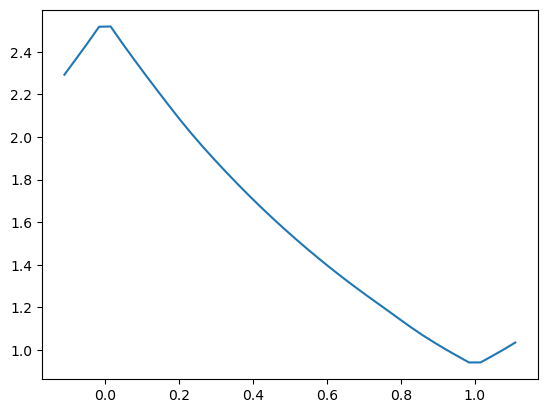

In [7]:
fig, ax = plt.subplots()
ax.plot(e.grid.x, e.U[:, 2])

In [6]:
e.evolve(1.0)

step:    1, t =  0.01321, dt =  0.01321
step:    2, t =  0.02631, dt =  0.01310
step:    3, t =  0.03937, dt =  0.01306
step:    4, t =  0.05242, dt =  0.01305
step:    5, t =  0.06546, dt =  0.01304
step:    6, t =  0.07850, dt =  0.01304
step:    7, t =  0.09155, dt =  0.01304
step:    8, t =   0.1046, dt =  0.01305
step:    9, t =   0.1176, dt =  0.01304
step:   10, t =   0.1307, dt =  0.01304
step:   11, t =   0.1437, dt =  0.01304
step:   12, t =   0.1568, dt =  0.01304
step:   13, t =   0.1698, dt =  0.01304
step:   14, t =   0.1828, dt =  0.01304
step:   15, t =   0.1959, dt =  0.01304
step:   16, t =   0.2089, dt =  0.01304
step:   17, t =   0.2220, dt =  0.01304
step:   18, t =   0.2350, dt =  0.01304
step:   19, t =   0.2480, dt =  0.01304
step:   20, t =   0.2611, dt =  0.01304
step:   21, t =   0.2741, dt =  0.01304
step:   22, t =   0.2871, dt =  0.01304
step:   23, t =   0.3002, dt =  0.01304
step:   24, t =   0.3132, dt =  0.01304
step:   25, t =   0.3263, dt =  0.01303
